# Workshop 3: Phylogenetic Trees

Welcome to the last workshop! In this workshop, you will learn some basic skills of working with graphs in python and apply these to implement some of the tree reconstruction algorithms we discussed in the workshop presentation. You will then see how you can quickly call methods from biopython to do equivalent operations. 

The workshop is divided into three main sections: 
1. Preliminary (Introducing networkx)
2. Algorithms From Scratch
3. Biopython (Phylo Module)

> Note: Question difficulty has been flagged with asterisks (* = easy, ** = medium, *** = difficult) 

In [46]:
# HELPER FUNCTIONS (don't edit!)

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy

# HELPER FUNCTIONS
# (You do not need to edit these functions)
def CreateGraph(adjacency_list): 
    """
    Use networkx package to build a graph object 
    """
    G = nx.Graph()
    
    edge_list = []
    for weighted_edge in adjacency_list:
        # get the information in the right data type 
        edge, weight = weighted_edge.split(":")
        weight = int(weight)
        source = int(edge.split('->')[0])
        sink = int(edge.split('->')[1])
        
        G.add_node(source)
        edge_list.append((source, sink, weight))
        
    G.add_weighted_edges_from(edge_list)
    
    return G 

def PrintAdjacencyFromGraph(T):
    """
    Given a networkx graph, print an adjacency list representation of the graph 
    """
    adj_list = []
    for edge in T.edges():
        adj_list.append("{0}->{1}:{2:.3f}".format(edge[0], edge[1], (T[edge[0]][edge[1]]["weight"])))
        adj_list.append("{1}->{0}:{2:.3f}".format(edge[0], edge[1], (T[edge[0]][edge[1]]["weight"])))

    print('\n'.join(sorted(adj_list)))
    return

def LoadCovidDistanceMatrix():
    """
    Loads in the additive distance matrix generated from a multiple sequence alignment of coronavirus spike proteins
    
    Returns:
    - header : list of species 
    - distance_matrix
    """
    spike_dist_mat = []
    with open('coronavirus_distance_matrix_additive.txt') as f:
        header = f.readline().strip().split('\t')
        lines = f.readlines()
        for line in lines:
            spike_dist_mat.append([float(x) for x in line.strip().split('\t')[1:]])  
    spike_dist_mat = np.array(spike_dist_mat)
    return header, spike_dist_mat


## Part 1: Preliminary 

In python, there is a useful package called `networkx` which you can use to create graphs. We will first take a look at how we can draw some basic graphs so that we can incorporate these tools to help us build trees from scratch. 

> Note: You may need to `pip/conda install networkx` 

To create an undirected graph in networkx, we can call the method `.Graph()`. When importing the networkx package, we can give it an *alias* `nx`. This is the standard name (you can give it any name you want) and it just makes it easier for us to use the package. 

In [2]:
import networkx as nx

# create a graph 
myGraph = nx.Graph()
myGraph

Currently our graph has been instantiated, the next step is to add nodes and edges. 

In [12]:
# add a node with label 'A'
myGraph.add_node('A')

# add a node with an integer label
myGraph.add_node(0)

# add a node with an additional attribute 
myGraph.add_node('Sam', age=20)

# see the current nodes inside the graph 
print(myGraph.nodes)

# see the current nodes inside the graph with additional attribute data
print(myGraph.nodes.data(True))

['A', 0, 'Sam']
[('A', {}), (0, {}), ('Sam', {'age': 20})]


In [13]:
# add an edge between node 'A' and 0 with a weight of 10
myGraph.add_edge('A', 0, weight=10)

# see the edges of the graph
print(myGraph.edges)

# see the edges of the graph with any associated data
print(myGraph.edges.data(True))

# assign a weight to an edge 
myGraph['A'][0]['weight'] = 100
print(myGraph.edges.data(True))

[('A', 0)]
[('A', 0, {'weight': 10})]
[('A', 0, {'weight': 100})]


In [14]:
# remove a node 
myGraph.remove_node('Sam')
print(myGraph.nodes)

# remove an edge 
myGraph.remove_edge('A', 0)
print(myGraph.edges)

['A', 0]
[]


### Q1. Create a Graph*
Create a graph representation of an unrooted tree with 4 leaves (A, B, C, D). Leaves A, B belong to a clade and Leaves C, D belong to another clade. You will need to create necessary internal nodes and you can name these whatever you'd like. 

> Hint: To check what your tree looks like you can use the method nx.draw(graph)

In [ ]:
# Type your code here

### Q2. Edit a Graph*
Remove an edge to form two valid subtrees. Assign the limb lengths for the subtrees to 1. 

In [26]:
# Type your code here


## Part 2: Algorithms From Scratch

We will first take a look at computing our own distance matrix. A simple and commonly used distance metric is the Hamming Distance between two strings. This is simply the number of mismatches between the two strings. 

### Q3.  Hamming Distance *

Implement a function that computes the Hamming Distance between two strings. 
> Assume the sequences are of equal length. 

In [ ]:
def HammingDistance(seq1, seq2):
    
    # Write your code here
    
    return distance

# Test your function 
HammingDistance('ACGTAGGCCT', 'ATGTAAGACT')  # Your function should return 3

### Q4. Distance Matrix *

Implement a function that takes in a list of aligned sequences and returns a distance matrix with each entry being the hamming distance between two strings. 

> Hint: It is helpful to use np.zeros() to initialise your matrix

In [30]:
def CreateDistanceMatrix(aligned_sequences):
    
    # Write your code here
    
    return D

# Test your code 
sequences = ['ACGTAGGCCT', 'ATGTAAGACT', 'TCGAGAGCAC', 'TCGAAAGCAT']

In [2]:
# ANSWER
import numpy as np
def CreateDistanceMatrix(aligned_sequences):
    
    n = len(aligned_sequences)
    
    D = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            D[i][j] = HammingDistance(aligned_sequences[i], aligned_sequences[j])
                
    return D

# Test your code 
sequences = ['ACGTAGGCCT', 'ATGTAAGACT', 'TCGAGAGCAC', 'TCGAAAGCAT']

CreateDistanceMatrix(sequences)

NameError: name 'HammingDistance' is not defined

### UPGMA

UPGMA stands for Unweighted Pair Group Method with Arithmetic Mean. It is a simple clustering heuristic for constructing an evolutionary tree. If you have come across hierarchical or agglomerative clustering before. The idea is the same. 

We have already mentioned how the algorithm works during the presentation. However, if you find it easier to read and understand here is a written explanation: 

We first start off with our $n\times n$ distance matrix $D$. We then start by assigning each leaf as its own cluster. We then find the pair of "closest" clusters which will be the minimum non-diagonal element of the distance matrix. We merge these two clusters (i.e. remove the two and form a new cluster with the elements combined). In terms of the tree, this involves creating a new internal node and connecting it to the nodes representing the clusters merged. The edge length is just set as half the distance between the merged clusters. Finally, we recompute the distances between the new clusters and repeat until we have only 1 cluster remaining. 

The distance between clusters is just the average distance between all elements in each cluster; hence the name "Arithmetic Mean". 

$$ D_{C_1, C_2} = \frac{\sum_{i\in C_1}\sum_{j\in C_2 D_{i,j}}}{|C_1||C_2|}$$ 


`UPGMA(D, n) 
    Clusters ← n single-element clusters labeled 1, ... , n
    construct a graph T with n isolated nodes labeled by single elements 1, ... , n
    for every node v in T 
        Age(v) ← 0
    while there is more than one cluster
        find the two closest clusters Ci and Cj  
        merge Ci and Cj into a new cluster Cnew with |Ci| + |Cj| elements
        add a new node labeled by cluster Cnew to T
        connect node Cnew to Ci and Cj by directed edges  
        Age(Cnew) ← DCi, Cj / 2
        remove the rows and columns of D corresponding to Ci and Cj 
        remove Ci and Cj from Clusters 
        add a row/column to D for Cnew by computing D(Cnew, C) for each C in Clusters
        add Cnew to Clusters
    root ← the node in T corresponding to the remaining cluster
    for each edge (v, w) in T
        length of (v, w) ← Age(v) - Age(w)
    return T`

### Q5. UPGMA ***
Implement the UPGMA algorithm described by the pseudocode above. 

> Hint: you may want to break down some of the steps in the pseudocode into their own functions to make life easier. 

In [ ]:
def UPGMA(D, n):
    """
    Parameters:
    D (n x n matrix) - distance matrix
    n (int) - number of leaves
    
    Returns:
    T (networkx graph object) - tree
    """
    
    
    return T


# Test your code 
n = 4 

D = np.array([[0, 20, 17, 11],
     [20, 0, 20, 13],
     [17, 20, 0, 10],
     [11, 13, 10, 0]
    ])

UPGMA_tree = UPGMA(D,n)

PrintAdjacencyFromGraph(UPGMA_tree)

In [32]:
# ANSWER 
def getMinMatrix(clusters, D):
    """Returns the clusters that are minimal distance apart and the distance value"""
    minimum = np.inf 
    min_i = 0
    min_j = 0

    for cluster_i in clusters.keys():
        for cluster_j in clusters.keys():
            distance_between_cluster = 0
            for i in clusters[cluster_i]:
                for j in clusters[cluster_j]:
                    distance_between_cluster += D[i][j]
                    
            distance_between_cluster /= float(len(clusters[cluster_i])*len(clusters[cluster_j]))
            
            if distance_between_cluster < minimum and cluster_i!=cluster_j:
                minimum = distance_between_cluster
                min_i = cluster_i
                min_j = cluster_j
    
    return (min_i, min_j, minimum)


def UPGMA(D, n):
    """
    Parameters:
    D (n x n matrix) - distance matrix
    n (int) - number of leaves
    """
    clusters = { i: [i] for i in range(n)}
    
    cluster_new_ind = len(clusters) 
    
    T = nx.DiGraph()
    
    for i in clusters.keys():
        T.add_node(i, age=0)
        
    
    while len(clusters) > 1:
        # get the minimum non diagonal entry of the matrix 
        cluster_i, cluster_j, D_ij = getMinMatrix(clusters, D)
        
        # merge the clusters into a new cluster 
        clusters[cluster_new_ind] = clusters[cluster_i] + clusters[cluster_j]
        
        # old clusters have to be removed 
        del clusters[cluster_i]
        del clusters[cluster_j]
        
        # add new cluster to T
        T.add_node(cluster_new_ind, age=D_ij/2)
        
        # connect new cluster to cluster_i, cluster_j with edges with weight D_ij/2 
        T.add_edge(cluster_new_ind, cluster_i)
        T.add_edge(cluster_new_ind, cluster_j)
        
        cluster_new_ind +=1
        
    root = cluster_new_ind -1 # most recently added cluster 
    for edge in T.edges:
        v = edge[0]
        w = edge[1]
        
        T[v][w]['weight'] = T.nodes[v]['age'] - T.nodes[w]['age']
        
    return T 
    
n = 4 

D = np.array([[0, 20, 17, 11],
     [20, 0, 20, 13],
     [17, 20, 0, 10],
     [11, 13, 10, 0]
    ])

UPGMA_tree = UPGMA(D,n)

PrintAdjacencyFromGraph(UPGMA_tree)

0->5:7.000
1->6:8.833
2->4:5.000
3->4:5.000
4->2:5.000
4->3:5.000
4->5:2.000
5->0:7.000
5->4:2.000
5->6:1.833
6->1:8.833
6->5:1.833


### Neighbour Joining

The Neighbour Joining (NJ) algorithm is widely used for evolutionary tree reconstruction. The weakness of UPGMA is that it assumes the minimum element in the distance matrix are neighbours, yet this is not always the case. NJ converts the distance matrix into another matrix so that the minimum non diagonal element of the matrix does guarantee a pair of neighbours. 

The conversion is based on the idea that instead of simply comparing distances between leaves, we now subtract off the total distance from the leaves to all other leaves. Mathematically, the transformed matrix $D^*$ is 

$$ D^*_{i,j}=  D_{ij} - AverageDistance_D(i) - AverageDistance_D(j)$$ 

where $ AverageDistance_D(i) = \frac{\sum_{i \leq k \leq n} D_{i,k}}{n-2}$ 



### Q6. Neighbour Joining Transformation **

Implement the transformation operation of the neighbour joining method 

> Hint: the `.sum()` method will be useful 

In [ ]:
def Transformation(D):
    
    # Write your code here 
    
    return D_star

# Test your code 
D = np.array([[0, 5, 4, 7, 6, 8],
     [5, 0, 7, 10, 9, 11],
     [4, 7, 0, 7, 6, 8],
     [7, 10, 7, 0, 5, 9],
     [6, 9, 6, 5, 0, 8],
     [8, 11, 8, 9, 8, 0]]).astype('float')

Transformation(D)

# answer 
# array([[  0. , -13. , -11.5, -10. , -10. , -10.5],
#        [-13. ,   0. , -11.5, -10. , -10. , -10.5],
#        [-11.5, -11.5,   0. , -10.5, -10.5, -11. ],
#        [-10. , -10. , -10.5,   0. , -13. , -11.5],
#        [-10. , -10. , -10.5, -13. ,   0. , -11.5],
#        [-10.5, -10.5, -11. , -11.5, -11.5,   0. ]])

In [ ]:
# ANSWER 
def Transformation(D):

    # get the size of the matrix
    n = len(D)
    
    # create a copy of the matrix 
    # hint: .copy()
    D_star = D.copy()
    
    # iterate through upper or bottom triangle of matrix
    for i in range(n):
        for j in range(i+1, n):
            
            # calculate transformed value 
            # hint: .sum()
            D_star[i][j] = D[i][j] - (D[i].sum() + D[j].sum()) / (n-2)
            D_star[j][i] = D_star[i][j]
        
    return D_star
    

## Part 3: Using Biopython 

As mentioned in the last workshop, there are many tools available to produce multiple sequence alignments. Alternatively, multiple sequence alignments are available for download from databases like Rfam https://rfam.xfam.org and Pfam http://pfam.xfam.org. 

We will take full advantage of this by retrieving a MSA alignment for the family of coronaviruses located at http://pfam.xfam.org/family/PF01600#tabview=tab3. 
> Our alignment has been downloaded to the same folder as where this notebook is with the following options: 


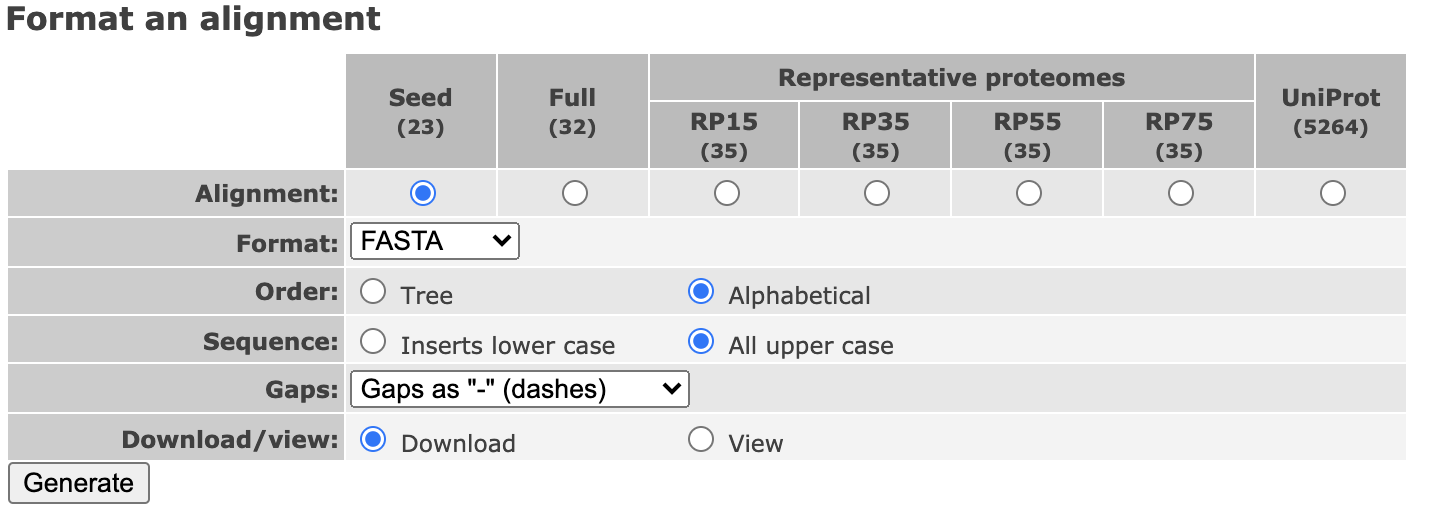

We can now read in the alignment as mentioned last workshop using the `Bio.AlignIO` module. 


In [39]:
from Bio import AlignIO
alignment = AlignIO.read("PF01600_seed (1).txt", "fasta")

The `Bio.Phylo` module contains methods that allows us to calculate the distance matrix easily. We use the simplest 'identity' distance metric which is similar to that of the hamming distance as shown previously 

In [38]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator 

calculator = DistanceCalculator('identity')
distance_matrix = calculator.get_distance(alignment)

Finally, we can simply create a tree constructor to build the tree that we desire. 

In [42]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

constructor = DistanceTreeConstructor(calculator)
covid_tree = constructor.build_tree(alignment)

# This is equivalent to constructor.nj(distance_matrix)
# Alternatively, to draw a upgma tree, we can do:
# covid_tree = constructor.upgma(distance_matrix)
covid_tree.rooted = True

To visualise the tree, there are a few options. We could use matplotlib or we could simply render as ASCII. 

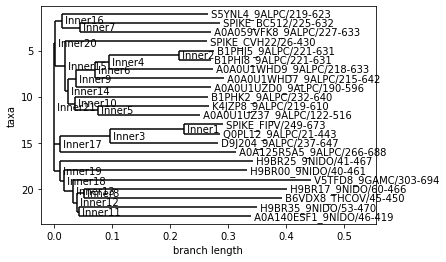

In [43]:
import matplotlib 
import matplotlib.pyplot as plt

fig = Phylo.draw(covid_tree)

As you can see above, the formatting is quite terrible, we can use matplotlib commands to make our plot prettier. 

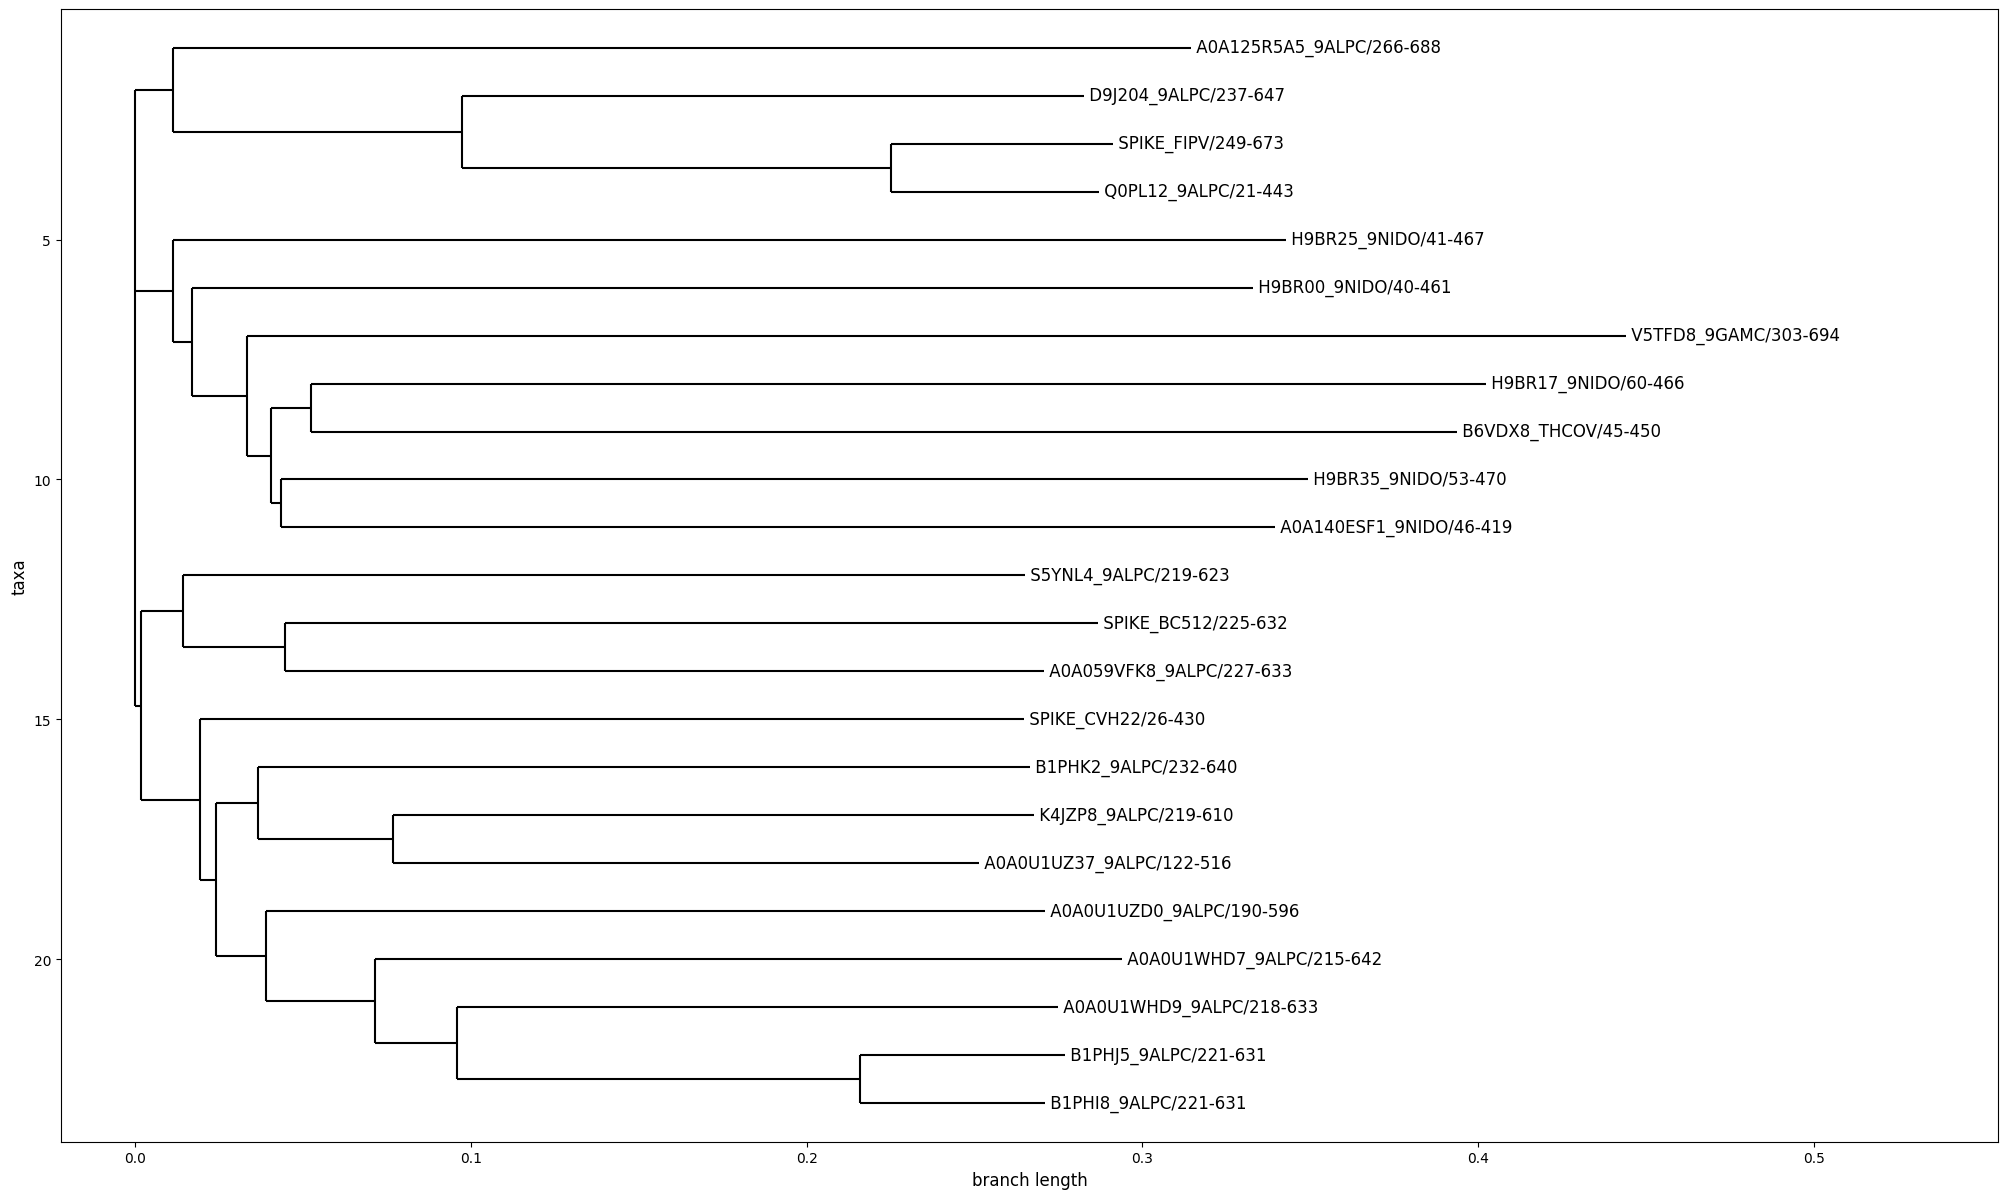

In [44]:
# Remove the clade labels associated with Inner
for clade in covid_tree.find_clades():
    if 'Inner' in clade.name:
        clade.name = ''

# Make a better looking tree using the features of matplotlib 
fig = plt.figure(figsize=(25, 15), dpi=100) # create figure & set the size 
matplotlib.rc('font', size=12)              # fontsize of the leaf and node labels 
matplotlib.rc('xtick', labelsize=10)       # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=10)       # fontsize of the tick labels

# reorganises the clades so the longer branches are at the bottom
covid_tree.ladderize()
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(covid_tree, axes=axes)


In [45]:
Phylo.draw_ascii(covid_tree)

   _________________________________ A0A125R5A5_9ALPC/266-688
 ,|
 ||         ____________________ D9J204_9ALPC/237-647
 ||________|
 |         |               ______ SPIKE_FIPV/249-673
 |         |______________|
 |                        |______ Q0PL12_9ALPC/21-443
 |
 | ____________________________________ H9BR25_9NIDO/41-467
 ||
 ||___________________________________ H9BR00_9NIDO/40-461
 ||
 ||  ______________________________________________ V5TFD8_9GAMC/303-694
 || |
_||_|  _______________________________________ H9BR17_9NIDO/60-466
 |  |,|
 |  |||______________________________________ B6VDX8_THCOV/45-450
 |  ||
 |   |__________________________________ H9BR35_9NIDO/53-470
 |   |
 |   |_________________________________ A0A140ESF1_9NIDO/46-419
 |
 | ___________________________ S5YNL4_9ALPC/219-623
 ,|
 ||    __________________________ SPIKE_BC512/225-632
 ||___|
 |    |________________________ A0A059VFK8_9ALPC/227-633
 |
 |  __________________________ SPIKE_CVH22/26-430
 | |
 | |  _

### Q7. Create a Tree using Biopython * 

Have a browse of different protein families at http://pfam.xfam.org/browse. You may select any protein family, however limit the sequences to a reasonable amount and try generate a distance based tree using biopython. 

In [ ]:
# Write your code here (OPTIONAL)